In [1]:
from pathlib import Path
import pandas as pd

## Load Data

In [2]:
x_relevance_data_path = Path(".") / "ml_data" / "x_relevance_data_v1.pd.json"
y_relevance_data_path = Path(".") / "ml_data" / "y_relevance_data_v1.pd.json"
x_relevance_data = pd.read_json(x_relevance_data_path)
y_relevance_data = pd.read_json(y_relevance_data_path)

## Preprocess Data (only Abstract!)

In [3]:
import re
import ftfy
from unidecode import unidecode
import nltk
from nltk import tokenize
from textblob import Word
from nltk.stem import PorterStemmer
#nltk.download()
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
import string
punctuation_pattern = re.compile("[^\w\s]")
sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')
punctuation_characters = "".join((set(string.punctuation) - set(r"""&<=>'~+-%""")))
table = str.maketrans('', '', string.punctuation)
stop = stopwords.words("english")
st = PorterStemmer()

def data_preprocessing_pipeline(abstract : string):
    # Fix unicode problems
    abstract = ftfy.fix_text(abstract)
    # Map Unicode to Ascii
    abstract = unidecode(abstract)
    #Make everything into lower case
    abstract = abstract.lower().strip()
    #Remove Punctuation
    abstract = abstract.translate(table)
    return abstract

def tokenize_pipeline(abstract: string):
    abstract = tokenize.word_tokenize(abstract)
    abstract = [st.stem(wrd) for wrd in abstract if wrd not in stop]
    abstract = [Word(wrd).lemmatize() for wrd in abstract]
    return abstract


In [6]:
tfid_vectorizer = TfidfVectorizer(preprocessor=data_preprocessing_pipeline, tokenizer=tokenize_pipeline, max_features=10000, ngram_range=(1,1))
tfid_vectorizer.stop_words = None
tfid_vectorizer = tfid_vectorizer.fit(x_relevance_data.loc[:, "abstract"])

## Train, Test, Validate Split

In [9]:
import sklearn
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x_relevance_data, y_relevance_data, test_size=0.3, random_state=0)

In [28]:
x_train_tfidf = tfid_vectorizer.transform(X_train["abstract"])
x_test_tfidf = tfid_vectorizer.transform(X_test["abstract"])

In [33]:
from sklearn import metrics, naive_bayes, linear_model
from sklearn.metrics import ConfusionMatrixDisplay

In [104]:
import numpy as np
def train_model(classifier, x_train_feature_vec, y_train, x_test_feature_vec, y_test):
    classifier = classifier.fit(x_train_feature_vec, y_train)
    predictions=classifier.predict(x_test_feature_vec)
    return (metrics.accuracy_score(y_test, predictions), 
            metrics.classification_report(y_test, predictions),
            metrics.confusion_matrix(y_test, predictions))

def train_regression_model(threshold, classifier, x_train_feature_vec, y_train, x_test_feature_vec, y_test):
    classifier = classifier.fit(x_train_feature_vec, np.where(y_train==1, 1, -1))
    predictions=classifier.predict(x_test_feature_vec)
    print(predictions[0:10])
    predictions_cls = predictions>threshold
    return (metrics.accuracy_score(y_test, predictions_cls), 
            metrics.classification_report(y_test, predictions_cls),
            metrics.confusion_matrix(y_test, predictions_cls))

In [56]:
LM = linear_model.LogisticRegression(n_jobs=-1, multi_class="ovr", class_weight="balanced", solver="saga", max_iter=100000)
LM_acc, LM_report, LM_confusion_matrix = train_model(LM, x_train_tfidf, y_train, x_test_tfidf, y_test)
print(f"Accuracy of the linear model is {LM_acc}")

Accuracy of the linear model is 0.6038306869532772


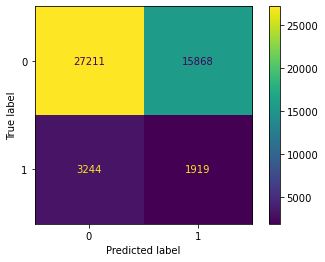

In [57]:
cmd = ConfusionMatrixDisplay(LM_confusion_matrix)
cmd.plot()

In [54]:
NB = naive_bayes.BernoulliNB(alpha=0.2, class_prior=[0.2, 0.8])
NB_acc, NB_report, NB_confusion_matrix = train_model(NB, x_train_tfidf, y_train, x_test_tfidf, y_test)
print(f"Accuracy of the nb model is {NB_acc}")

Accuracy of the nb model is 0.27478131089092495


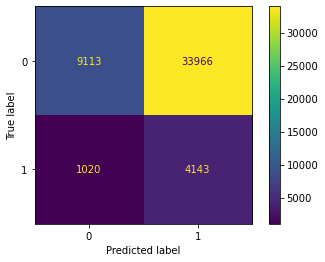

In [55]:
cmd = ConfusionMatrixDisplay(NB_confusion_matrix)
cmd.plot()

In [65]:
import xgboost
xgb = xgboost.XGBClassifier(n_estimators=250, n_jobs=-1,  use_label_encoder=False, max_depth=10, scale_pos_weight=9 )
xgb_acc, xgb_report, xgb_confusion_matrix = train_model(xgb, x_train_tfidf, y_train, x_test_tfidf, y_test)
print(f"Accuracy of the nb model is {xgb_acc}")

[18:30:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy of the nb model is 0.709174578168401


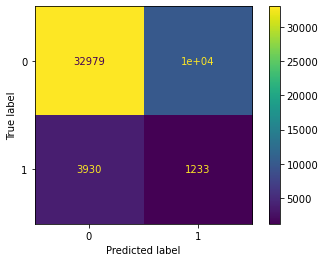

In [66]:
cmd = ConfusionMatrixDisplay(xgb_confusion_matrix)
cmd.plot()

In [74]:
from sklearn.ensemble import AdaBoostClassifier

ABC = AdaBoostClassifier(n_estimators=200, base_estimator=linear_model.LogisticRegression(n_jobs=-1, multi_class="ovr", class_weight="balanced", max_iter=1000))

abcLR_acc, abcLR_report, abcLR_confusion_matrix = train_model(ABC, x_train_tfidf, y_train, x_test_tfidf, y_test)
print(f"Accuracy of the nb model is {abcLR_acc}")

Accuracy of the nb model is 0.6199784420214751


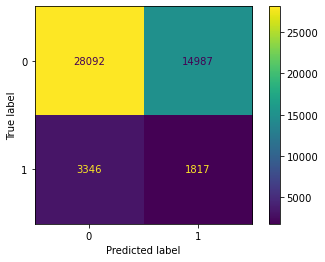

In [75]:
cmd = ConfusionMatrixDisplay(abcLR_confusion_matrix)
cmd.plot()

In [109]:
en = linear_model.ElasticNet(alpha=1, max_iter=1000, tol = 1e-8)
en_acc, en_report, en_confusion_matrix = train_regression_model(0, en, x_train_tfidf, y_train, x_test_tfidf, y_test)

[-0.78486523 -0.78486523 -0.78486523 -0.78486523 -0.78486523 -0.78486523
 -0.78486523 -0.78486523 -0.78486523 -0.78486523]


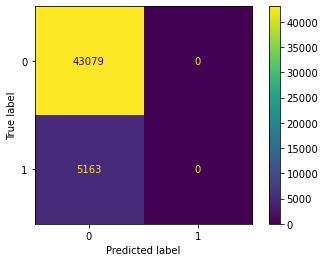

In [110]:
cmd = ConfusionMatrixDisplay(en_confusion_matrix)
cmd.plot()

1